In [1]:
import sys

import numpy as np

sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")
sys.path.append("../")

import hashlib

from data_factory.preprocessing import *
from utilities.config import load_config

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns
sns.set_style('darkgrid')

tqdm.pandas()


In [2]:
config_file = '../config/config.yml'
use_previous_files = False
export = False

In [3]:
config = load_config(config_file)

model = config['model']
model_config = config[model]

# Create variables from config
#  data loading
save_folder = config['data']['save']
train_file = config['data']['train_path'] + config['data']['stock_prices']
test_file = config['data']['test_path'] + config['data']['stock_prices']

#  TimeSeries settings
max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

related_stocks = model_config['related_stock']
train_val_split = model_config['train_val_split']
scale = model_config['manual_scale']

# define file name for saving StockPricesLoader with specific config
hash_ = hashlib.md5(model_config.__str__().encode('utf-8')).hexdigest()
export_file_name = f"{save_folder}/export_{hash_}.p"

print(f'Export file {export_file_name}')
print(f'Use config {config}')


Export file ../data/save//export_33330b8610da212bf1f1161f2e2ce8c7.p
Use config {'device': 'cpu', 'seed': False, 'model': 'temporal_fusion_transformer', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_prices.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 80, 'min_encoder_length': 80, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 2, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 5, 'min_prediction_length': 5, 'max_encoder_length': 150, 'min_encoder_length': 150, 'bat

### Load

In [4]:
from data_factory.prepared_data import PreparedData

data: PreparedData = PreparedData.from_file("../data/save/preprocessed_data.pkl")
df_train = data.train
df_val = data.val
df_test = data.test

df_val = df_val.groupby('SecuritiesCode').progress_apply(lambda x: x.loc[x.Date > df_train.loc[df_train.SecuritiesCode == x.name, 'Date'].max()]).reset_index(drop=True)
df_test = df_test.groupby('SecuritiesCode').progress_apply(lambda x: x.loc[x.Date > df_val.loc[df_train.SecuritiesCode == x.name, 'Date'].max()]).reset_index(drop=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Indicators

In [28]:
sc_ex = df_test.SecuritiesCode.unique()[0]
dft_sx = df_train[df_train.SecuritiesCode == sc_ex].copy()
dfv_sx = df_val[df_val.SecuritiesCode == sc_ex].copy()
dfe_sx = df_test[df_test.SecuritiesCode == sc_ex].copy()

dft_sx.reset_index(drop=True, inplace=True)
dfv_sx.reset_index(drop=True, inplace=True)
dfe_sx.reset_index(drop=True, inplace=True)

dfv_sx['idx'] = dfv_sx.index + dft_sx.index.max()
dfe_sx['idx'] = dfe_sx.index + dfv_sx.idx.max()
dfv_sx.set_index('idx', inplace=True)
dfe_sx.set_index('idx', inplace=True)

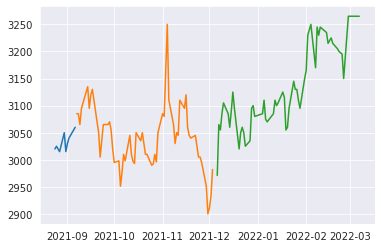

In [32]:
plt.plot(dft_sx.Date.iloc[-10:], dft_sx.Close.iloc[-10:])
plt.plot(dfv_sx.Date,dfv_sx.Close)
plt.plot(dfe_sx.Date,dfe_sx.Close)

In [6]:
dft_sx.Date.min(), dft_sx.Date.max()

(Timestamp('2017-01-06 00:00:00'), Timestamp('2021-09-06 00:00:00'))

In [7]:
dfv_sx.Date.min(), dfv_sx.Date.max()

(Timestamp('2021-09-07 00:00:00'), Timestamp('2021-12-03 00:00:00'))

In [8]:
def plot_indicators(df: pd.DataFrame, col: str, sc=sc_ex, span=30):
    df_ = df[df.SecuritiesCode == sc]
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 7), gridspec_kw={'height_ratios': [3, 1], 'hspace':.03})

    axs[0].plot(df_.Date, df_[col], label="price")
    axs[0].plot(df_.Date, df_[f'{col}_SMA{span}'], label="moving average")
    axs[0].plot(df_.Date, df_[f'{col}_CMA{span}'], label="cumulative moving average")
    axs[0].plot(df_.Date, df_[f'{col}_EWMA{span}'], label="exponentially weighted moving average")
    axs[1].plot(df_.Date, df_[f'{col}_STD{span}'], label="standard derivation")

    axs[0].legend()
    axs[1].legend()

def dickey_fuller_test(s: pd.Series):
    result = adfuller(s)
    print(f'ADF Statistics {result[0]}')
    print(f'p-value {result[1]}')
    print(f'Critical values')
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

def indicators(df: pd.DataFrame, col: str, *, sc=sc_ex, span=30):
    df[f'{col}_SMA{span}'] = df.groupby('SecuritiesCode')[col].rolling(span).mean().reset_index(drop=True)  # simple moving average
    df[f'{col}_STD{span}'] = df.groupby('SecuritiesCode')[col].rolling(span).std().reset_index(drop=True)  # standard derivation
    df[f'{col}_CMA{span}'] = df.groupby('SecuritiesCode')[col].expanding().mean().reset_index(drop=True)  # cumulative moving average
    df[f'{col}_EWMA{span}'] = df.groupby('SecuritiesCode')[col].ewm(span=span).mean().reset_index(drop=True)  # exponentially weighted moving average

    plot_indicators(df, col, sc, span)
    dickey_fuller_test(df[df.SecuritiesCode == sc][col])

#### Price analysis

ADF Statistics -1.813820312443683
p-value 0.3736221995593553
Critical values
	1%: -3.4361042569951805
	5%: -2.8640808675675826
	10%: -2.568122823703617


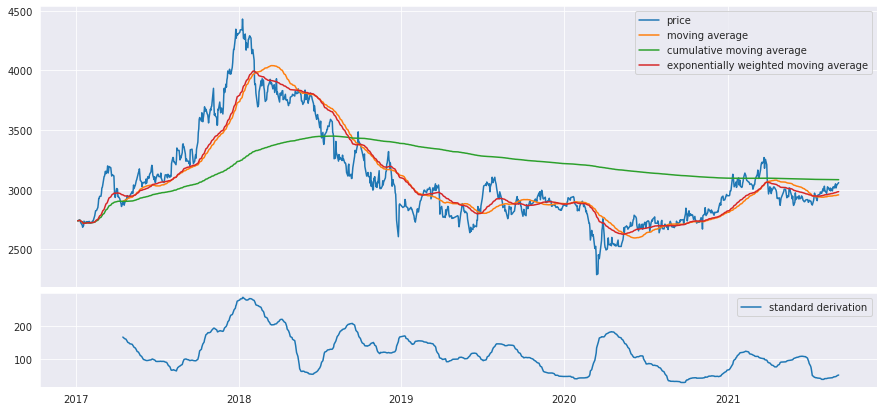

In [9]:
span = 70
indicators(df_train, 'Close', span=span)

#### Price minus moving average analysis

ADF Statistics -3.783539042096147
p-value 0.0030802942909856205
Critical values
	1%: -3.4364762217105844
	5%: -2.8642449457774135
	10%: -2.5682102104987337


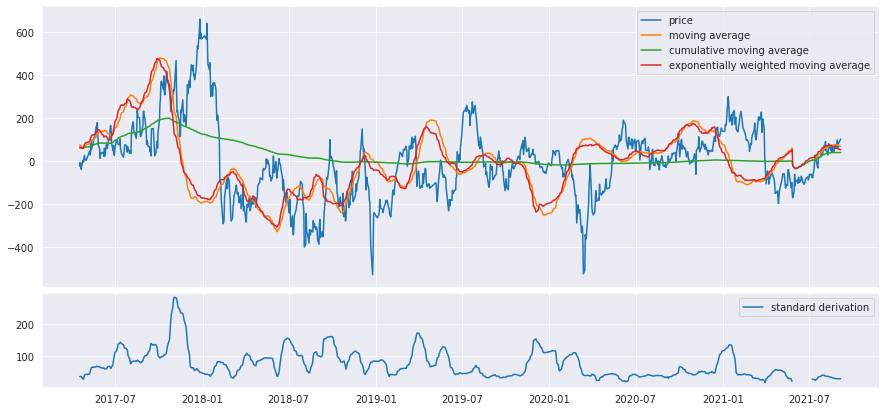

In [10]:
df_train[f'Close_minus_SMA{span}'] = df_train.Close - df_train[f'Close_SMA{span}']
df_train_filtered = df_train[[f'Close_minus_SMA{span}', 'SecuritiesCode', 'Date']].copy()
df_train_filtered.dropna(subset=[f'Close_minus_SMA{span}'], inplace=True)

indicators(df_train_filtered, f'Close_minus_SMA{span}')


Moving average and std are approximately horizontal. p-value is above .05 and ADF statistic is close to critical values. Therefore the timeseries is stationary

#### Exponential decay

ADF Statistics -4.340081175574937
p-value 0.0003783330174776982
Critical values
	1%: -3.4361245824564977
	5%: -2.8640898339013243
	10%: -2.56812759902191


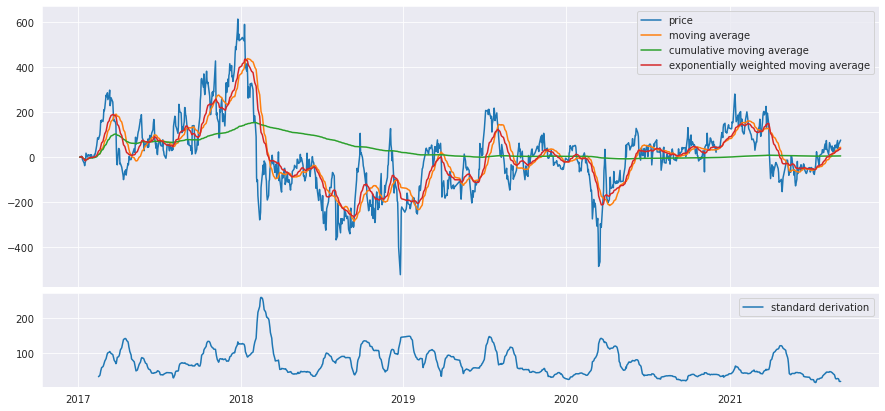

In [11]:
df_train[f'Close_minus_EWMA{span}'] = df_train.Close - df_train[f'Close_EWMA{span}']

indicators(df_train, f'Close_minus_EWMA{span}')

#### Previous value substraction

ADF Statistics -16.038979085799586
p-value 5.942801569992926e-29
Critical values
	1%: -3.4361245824564977
	5%: -2.8640898339013243
	10%: -2.56812759902191


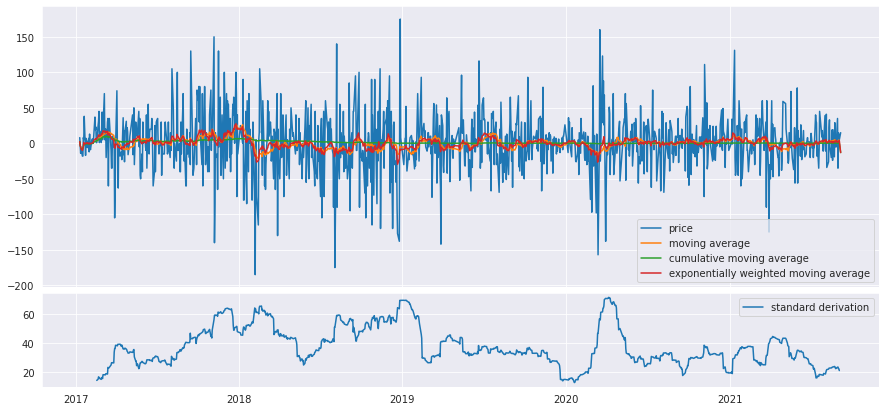

In [12]:
df_train[f'Close_diff1'] = df_train.groupby('SecuritiesCode').Close.diff()
df_train_filtered = df_train[[f'Close_diff1', 'SecuritiesCode', 'Date']].copy()
df_train_filtered.dropna(subset=[f'Close_diff1'], inplace=True)

indicators(df_train_filtered, f'Close_diff1')

### PACF & ACF

## ARIMA Model

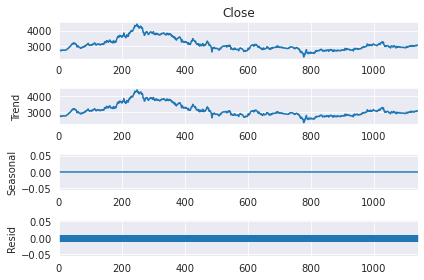

In [13]:
decomposition = seasonal_decompose(dft_sx.Close, period=1, model='additive')
p = decomposition.plot()

So, this is not decomposable

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11619.829, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11616.319, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11618.271, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11618.265, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11614.377, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.502 seconds
1140 1199 (59,)


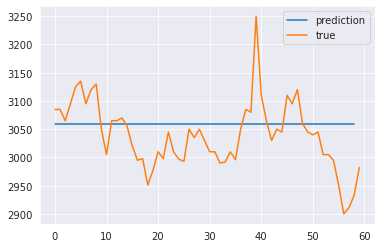

In [14]:
from pmdarima import auto_arima

stepwise_fit: ARIMA = auto_arima(
    dft_sx.Close,
    start_p=1, start_q=1,
    max_p=50, max_q=50, seasonal=False,
    d=None, D=1,
    trace=True, error_action='ignore',
    supress_warnings=False,
    stepwise=True
)
stepwise_fit.summary()

start = len(dft_sx)
end = len(dft_sx) + len(dfv_sx) - 1
predictions = stepwise_fit.predict(end - start)
print(start, end, predictions.shape)
plt.plot(predictions, label='prediction')
plt.plot(dfv_sx.index, dfv_sx.Close, label='true')
plt.legend()

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CPU times: user 3.62 s, sys: 8.11 ms, total: 3.63 s
Wall time: 2.23 s


/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1140
Model:                ARIMA(10, 1, 5)   Log Likelihood               -5797.561
Date:                Mon, 13 Jun 2022   AIC                          11627.121
Time:                        17:51:12   BIC                          11707.728
Sample:                             0   HQIC                         11657.563
                               - 1140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4052      0.637     -0.636      0.525      -1.654       0.844
ar.L2         -0.2824      0.296     -0.955      0.340      -0.862       0.297
ar.L3          0.2663      0.316      0.842      0.400      -0.354       0.886
ar.L4          0.8030      0.237      3.387      0.001       0.338       1.268
ar.L5          0.3599      0.523      0.689      0.491      -0.664       1.384
ar.L6          0.0265      0.043      0.622      0.534      -0.057       0.110
ar.L7         -0.0476      0.048     -1.001      0.317      -0.141       0.046
ar.L8         -0.0643      0.046     -1.384      0.166      -0.155       0.027
ar.L9         -0.0226      0.060     -0.376      0.707      -0.140       0.095
ar.L10         0.0471      0.036      1.292      0.196      -0.024       0.119
ma.L1          0.4138      0.641      0.646      0.518      -0.842       1.670
ma.L2          0.2440      0.296      0.824      0.410      -0.336       0.824
ma.L3         -0.2764      0.296     -0.934      0.350      -0.856       0.304
ma.L4         -0.7535      0.233     -3.232      0.001      -1.210      -0.297
ma.L5         -0.3431      0.491     -0.699      0.484      -1.305       0.619
sigma2      1541.8240     50.272     30.669      0.000    1443.292    1640.356
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               216.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

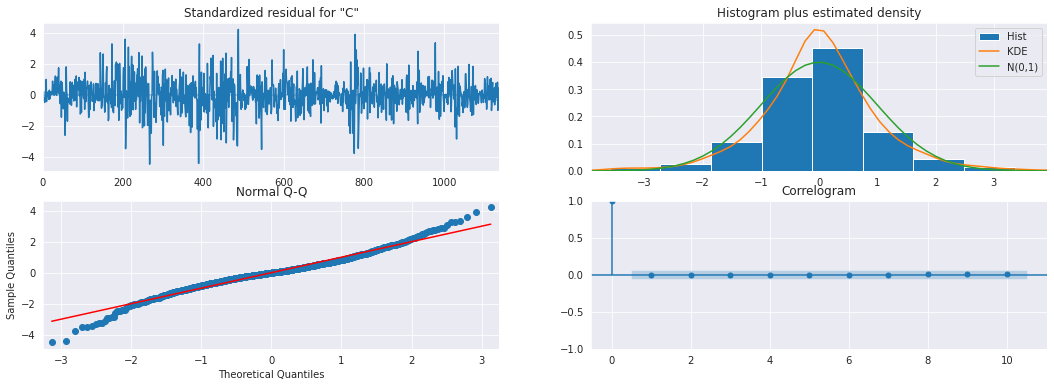

In [15]:
%%time

model = ARIMA(dft_sx.Close, order=(10, 1, 5))  # 50 1 3 did ok
results = model.fit()

results.plot_diagnostics(figsize=(18, 6))
results.summary()

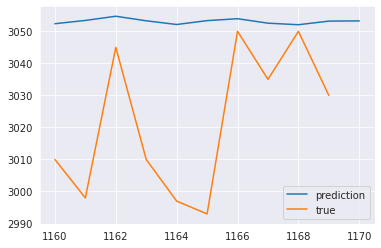

In [16]:
start = len(dft_sx) + 20
end = start + len(dfv_sx) - 1
end = start + 10
predictions = results.predict(start, end)

plt.plot(predictions, label='prediction')
plt.plot((dfv_sx.index + len(dft_sx))[start - len(dft_sx):start - len(dft_sx) + (end - start)], dfv_sx.Close[start - len(dft_sx):start - len(dft_sx) + (end - start)], label='true')
plt.legend()

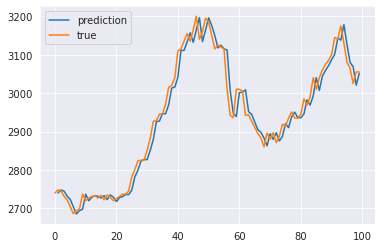

In [17]:
start = 1
end = len(dft_sx)
predictions = results.predict()

plt.plot(predictions[1:100], label='prediction')
plt.plot(dft_sx[:100].index, dft_sx[:100].Close, label='true')
plt.legend()

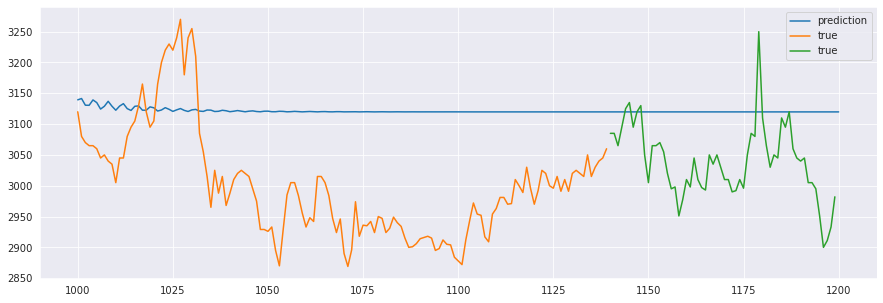

In [18]:
start = 1000
end = 1200
predictions = results.predict(start, end, dynamic=0)
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='prediction')
plt.plot(dft_sx.index[start: end], dft_sx.Close[start: end], label='true')
plt.plot(dfv_sx.index[0: end - len(dft_sx)] + len(dft_sx), dfv_sx.Close[0: end-len(dft_sx)], label='true')
plt.legend()

In [19]:
a = results.get_prediction(1, 2, dynamic=0)

### Forecasting

In [14]:
dfv_sx_shifted = dfv_sx.copy()
dfv_sx_shifted.index += len(dft_sx)

### Train of each SecuritiesCode

In [15]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [16]:
k = 2

def eval(df_val_subset: pd.DataFrame):
    tp = ((df_val_subset.Target > 0) == (df_val_subset.Target_pred > 0)).sum()
    fp = ((df_val_subset.Target <= 0) == (df_val_subset.Target_pred > 0)).sum()
    tn = ((df_val_subset.Target <= 0) == (df_val_subset.Target_pred <= 0)).sum()
    fn = ((df_val_subset.Target > 0) == (df_val_subset.Target_pred <= 0)).sum()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return pd.DataFrame([dict(
        tp=tp,
        tn=tn,
        fp=fp,
        fn=fn,
        f1= f1,
        precision=precision,
        recall=recall
    )])

def forecast_on_sc(df_: pd.DataFrame, df_train_subset:pd.DataFrame, model_, is_train_set: bool = False):
    df_.set_index('idx', inplace=True)
    forecasts_ = []

    if is_train_set is False:
        model_ = model_.append(df_.Close, refit=False)

    for i in df_.index:
        forecasts_.append(model_.predict(start=i, end=i+k-1, dynamic=0))

    forecasts_1 = pd.Series([e[0] for e in forecasts_],  index=df_.index)
    df_['Close_pred'] = forecasts_1
    df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)

    start = max(df_.index.min() - 50, 1)
    if is_train_set:
        print(f'{start=}')
    end = df_.index.max()
    # plt.figure(figsize=(15, 3))
    # plt.plot(df_.loc[start:end, 'Date'], forecasts_1.loc[start:end], label='prediction')

    dft_tc = df_train_subset[df_train_subset.SecuritiesCode == df_.name].copy()
    dft_tc.set_index('idx', inplace=True)

    # if not is_train_set:
    #     plt.plot(dft_tc.loc[start:, 'Date'], dft_tc.loc[start:, 'Close'], label='true train set')
    # plt.plot(df_.loc[:end, 'Date'], df_.loc[:end, 'Close'], label='true' if is_train_set else 'true val set')
    # plt.legend()
    # plt.show()
    return df_.reset_index(drop=False)


def fit(number_of_sc:int = 20, orders=[(10, 1, 3)], gs_results=pd.DataFrame()):
    # Fitting
    scs = df_train.SecuritiesCode.unique()[:number_of_sc]

    df_train_subset = df_train.loc[df_train.SecuritiesCode.isin(scs)].copy()
    df_train_subset.loc[:, 'idx'] = df_train_subset.index
    df_train_subset['idx'] = df_train_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min())).reset_index(drop=True)

    for order in orders:
        print(order)
        ARIMAs = df_train_subset.groupby('SecuritiesCode').Close.progress_apply(lambda x: ARIMA(x.to_numpy(), order=order).fit()).to_frame('model')

    # Prepare val set
    df_val_subset = df_val.loc[df_val.SecuritiesCode.isin(scs)].copy()
    df_val_subset.loc[:, 'idx'] = df_val_subset.index
    df_val_subset['idx'] = df_val_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min()) + len(df_train[df_train.SecuritiesCode == x.name])).reset_index(drop=True)

    # Prepare test set
    df_test_subset = df_test.loc[df_test.SecuritiesCode.isin(scs)].copy()
    df_test_subset.loc[:, 'idx'] = df_test_subset.index
    df_test_subset['idx'] = df_test_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min()) + len(df_val[df_val.SecuritiesCode == x.name])).reset_index(drop=True)

    # Test
    for order in orders:
        # Eval on val set
        df_val_subset = df_val_subset.groupby('SecuritiesCode').progress_apply(lambda x: forecast_on_sc(x, df_train_subset, ARIMAs.loc[x.name][0], is_train_set=False)).reset_index(drop=True)
        df_val_subset[f'Close_pred_{order}'] = df_val_subset.Close_pred
        df_val_subset[f'Target_pred_{order}'] = df_val_subset.Target_pred

        ev = eval(df_val_subset)
        ev['config'] = str(order)
        ev['mode'] = 'val'
        gs_results = pd.concat([gs_results, ev])
        print(gs_results)

        # Eval on train set
        df_train_subset = df_train_subset.groupby('SecuritiesCode').progress_apply(lambda x: forecast_on_sc(x, df_train_subset, ARIMAs.loc[x.name][0], is_train_set=True)).reset_index(drop=True)
        df_train_subset[f'Close_pred_{order}'] = df_train_subset.Close_pred
        df_train_subset[f'Target_pred_{order}'] = df_train_subset.Target_pred

        ev = eval(df_train_subset)
        ev['config'] = str(order)
        ev['mode'] = 'train'
        gs_results = pd.concat([gs_results, ev])
        print(gs_results)

        # Test on test set
        df_test_subset = df_test_subset.groupby('SecuritiesCode').progress_apply(lambda x: forecast_on_sc(x, df_test_subset, ARIMAs.loc[x.name][0], is_train_set=True)).reset_index(drop=True)
        df_test_subset[f'Close_pred_{order}'] = df_test_subset.Close_pred
        df_test_subset[f'Target_pred_{order}'] = df_test_subset.Target_pred

        ev = eval(df_test_subset)
        ev['config'] = str(order)
        ev['mode'] = 'test'
        gs_results = pd.concat([gs_results, ev])
        print(gs_results)

    return gs_results

In [22]:
gs_results

,tp,tn,fp,fn,f1,precision,recall,config,mode
0,1465,1465,1457,1457,0.501369,0.501369,0.501369,"(10, 1, 1)",val
0,27551,27543,27969,27977,0.496200,0.496236,0.496164,"(10, 1, 1)",train
0,1514,1514,1536,1536,0.496393,0.496393,0.496393,"(10, 1, 1)",test
0,1465,1465,1457,1457,0.501369,0.501369,0.501369,"(2, 1, 1)",val
0,27551,27543,27969,27977,0.496200,0.496236,0.496164,"(2, 1, 1)",train
0,1514,1514,1536,1536,0.496393,0.496393,0.496393,"(2, 1, 1)",test
0,1525,1525,1397,1397,0.521903,0.521903,0.521903,"(25, 1, 1)",val
0,27611,27603,27909,27917,0.497280,0.497316,0.497245,"(25, 1, 1)",train
0,1477,1477,1573,1573,0.484262,0.484262,0.484262,"(25, 1, 1)",test


In [ ]:
plt.plot()

In [21]:
gs_results = fit(number_of_sc=50, orders=[(25, 1, 1)], gs_results=gs_results)

(25, 1, 1)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   
0   1465   1465   1457   1457  0.501369   0.501369  0.501369   (2, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164   (2, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393   (2, 1, 1)   
0   1525   1525   1397   1397  0.521903   0.521903  0.521903  (25, 1, 1)   

    mode  
0    val  
0  train  
0   test  
0    val  
0  train  
0   test  
0    val  


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1
start=1
      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   
0   1465   1465   1457   1457  0.501369   0.501369  0.501369   (2, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164   (2, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393   (2, 1, 1)   
0   1525   1525   1397   1397  0.521903   0.521903  0.521903  (25, 1, 1)   
0  27611  27603  27909  27917  0.497280   0.497316  0.497245  (25, 1, 1)   

    mode  
0    val  
0  train  
0   test  
0    val  
0  train  
0   test  
0    val  
0  train  


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


  0%|          | 0/50 [00:00<?, ?it/s]

start=10
start=10
start=10
start=1
start=10
start=10
start=10
start=10
start=10
start=7
start=10
start=10
start=10
start=10
start=1
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   
0   1465   1465   1457   1457  0.501369   0.501369  0.501369   (2, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164   (2, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393   (2, 1, 1)   
0   1525   1525   139

In [19]:
gs_results = fit(number_of_sc=50, orders=[(10, 1, 1), (2, 1, 1)])

(10, 1, 1)


  0%|          | 0/50 [00:00<?, ?it/s]

(2, 1, 1)


  0%|          | 0/50 [00:00<?, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  0%|          | 0/50 [00:00<?, ?it/s]

     tp    tn    fp    fn        f1  precision    recall      config mode
0  1465  1465  1457  1457  0.501369   0.501369  0.501369  (10, 1, 1)  val


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1
start=1
      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   

    mode  
0    val  
0  train  


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


  0%|          | 0/50 [00:00<?, ?it/s]

start=10
start=10
start=10
start=1
start=10
start=10
start=10
start=10
start=10
start=7
start=10
start=10
start=10
start=10
start=1
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   

    mode  
0    val  
0  train  
0   test  


  0%|          | 0/50 [00:00<?, ?it/s]

      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   
0   1465   1465   1457   1457  0.501369   0.501369  0.501369   (2, 1, 1)   

    mode  
0    val  
0  train  
0   test  
0    val  


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


start=1
start=1
      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   
0   1465   1465   1457   1457  0.501369   0.501369  0.501369   (2, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164   (2, 1, 1)   

    mode  
0    val  
0  train  
0   test  
0    val  
0  train  


/tmp/ipykernel_942174/311449914.py:34: RuntimeWarning: invalid value encountered in double_scalars
  df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)


  0%|          | 0/50 [00:00<?, ?it/s]

start=10
start=10
start=10
start=1
start=10
start=10
start=10
start=10
start=10
start=7
start=10
start=10
start=10
start=10
start=1
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
start=10
      tp     tn     fp     fn        f1  precision    recall      config  \
0   1465   1465   1457   1457  0.501369   0.501369  0.501369  (10, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164  (10, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393  (10, 1, 1)   
0   1465   1465   1457   1457  0.501369   0.501369  0.501369   (2, 1, 1)   
0  27551  27543  27969  27977  0.496200   0.496236  0.496164   (2, 1, 1)   
0   1514   1514   1536   1536  0.496393   0.496393  0.496393   (2, 1, 1)   

    mode  
0    val 

In [20]:
gs_results

,tp,tn,fp,fn,f1,precision,recall,config,mode
0,1465,1465,1457,1457,0.501369,0.501369,0.501369,"(10, 1, 1)",val
0,27551,27543,27969,27977,0.496200,0.496236,0.496164,"(10, 1, 1)",train
0,1514,1514,1536,1536,0.496393,0.496393,0.496393,"(10, 1, 1)",test
0,1465,1465,1457,1457,0.501369,0.501369,0.501369,"(2, 1, 1)",val
0,27551,27543,27969,27977,0.496200,0.496236,0.496164,"(2, 1, 1)",train
0,1514,1514,1536,1536,0.496393,0.496393,0.496393,"(2, 1, 1)",test
